# Import the necessary libraries

In [17]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Read the Train Dataset

In [3]:
file_path = r"E:\AI\AWS SageMaker\Session 2\Dataset\train.csv"
train_df = pd.read_csv(file_path)
train_df.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-12,Delhi,Cochin,09:45:00,08:15:00,1350,1.0,No Info,8991
1,Indigo,2019-03-15,Banglore,New Delhi,07:30:00,12:20:00,290,1.0,No Info,6114
2,Vistara,2019-06-12,Kolkata,Banglore,17:00:00,23:25:00,385,1.0,No Info,8610
3,Multiple Carriers,2019-06-01,Delhi,Cochin,07:05:00,16:10:00,545,1.0,No Info,9646
4,Jet Airways,2019-06-03,Delhi,Cochin,22:50:00,12:35:00,825,1.0,No Info,14714


In [4]:
train_df.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [7]:
train_df = train_df.assign(**{
    col: pd.to_datetime(train_df.loc[:, col], format='mixed')
    for col in ['date_of_journey', 'dep_time', 'arrival_time']
})

In [8]:
train_df.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

## Summary

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [13]:
train_df.describe(include='number')

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,644.562500,0.821875,9025.767187
std,506.470538,0.666307,4914.569879
min,75.000000,0.000000,1965.000000
25%,170.000000,0.000000,5198.000000
50%,545.000000,1.000000,8371.500000
75%,930.000000,1.000000,12346.250000
max,2315.000000,3.000000,54826.000000


In [14]:
train_df.describe(include='O')

,airline,source,destination,additional_info
count,640,640,640,640
unique,8,5,6,4
top,Jet Airways,Delhi,Cochin,No Info
freq,222,265,265,498


In [15]:
(
    train_df
    .assign(total_stops=train_df['total_stops'].astype(object))
    .describe(include='O')
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,4
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,222,265,265,348.0,498


## Outliers Analysis

### Isolation Forest - Anomaly Detection Algorithm

- Isolation Forest is an unsupervised machine learning algorithm primarily used for anomaly detection (also known as outlier detection).

- It works by randomly partitioning data points. The core idea is that anomalies are "few and different," so they tend to be isolated in fewer random partitions compared to normal data points.

- Think of it like this:

    - It builds multiple "isolation trees" (similar to decision trees).
    - In each tree, it randomly selects a feature and then randomly selects a split value between the minimum and maximum values of that feature.
    - This process continues until each data point is isolated in its own leaf node.
    - Anomalies, being outliers, are expected to be isolated much closer to the root of the tree (i.e., with fewer splits) than normal points.
    - The algorithm then calculates an anomaly score for each data point based on its average path length across all the trees in the forest. Shorter average path lengths indicate a higher likelihood of being an anomaly.

**How to interpret it:**

- If you use predict(), you get a direct classification: is it an anomaly or not?
- If you use decision_function(), you get a continuous score. This is often more useful because:
    - You can rank data points by their "outlierness."
    - You can choose your own threshold for classifying anomalies based on these scores, rather than relying on the default. For example, you might decide that only points with a score below -0.1 are considered strong anomalies.

In [18]:
forest = IsolationForest(n_estimators=10, random_state=42)  

In [22]:
(
    train_df
    .assign(is_outlier=forest.fit_predict(train_df
                                            .drop(columns='price')
                                            .select_dtypes(include='number')))
    .query('is_outlier==-1')
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,is_outlier
0,Air India,2019-06-12,Delhi,Cochin,2025-06-18 09:45:00,2025-06-18 08:15:00,1350,1.0,No Info,8991,-1
1,Indigo,2019-03-15,Banglore,New Delhi,2025-06-18 07:30:00,2025-06-18 12:20:00,290,1.0,No Info,6114,-1
5,Air India,2019-05-15,Delhi,Cochin,2025-06-18 05:15:00,2025-06-18 06:50:00,1535,1.0,No Info,8425,-1
9,Vistara,2019-05-21,Kolkata,Banglore,2025-06-18 20:20:00,2025-06-18 22:40:00,1580,1.0,No Info,8452,-1
12,Air India,2019-05-24,Kolkata,Banglore,2025-06-18 14:15:00,2025-06-18 16:45:00,150,0.0,No Info,5510,-1
...,...,...,...,...,...,...,...,...,...,...,...
633,Jet Airways,2019-06-18,Delhi,Cochin,2025-06-18 09:50:00,2025-06-18 13:05:00,195,0.0,In-flight meal not included,4466,-1
634,Jet Airways,2019-03-01,Banglore,New Delhi,2025-06-18 08:00:00,2025-06-18 07:40:00,1420,1.0,No Info,22270,-1
637,Vistara,2019-06-01,Chennai,Kolkata,2025-06-18 17:45:00,2025-06-18 20:05:00,140,0.0,No Info,11982,-1
638,Air India,2019-03-15,Banglore,New Delhi,2025-06-18 11:50:00,2025-06-18 08:55:00,1265,1.0,No Info,5932,-1


In [ ]:
(
    train_df
    .assign(outlier_score=forest.decision_function(train_df
                                            .drop(columns='price')
                                            .select_dtypes(include='number')))
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier_score
0,Air India,2019-06-12,Delhi,Cochin,2025-06-18 09:45:00,2025-06-18 08:15:00,1350,1.0,No Info,8991,-0.066747
1,Indigo,2019-03-15,Banglore,New Delhi,2025-06-18 07:30:00,2025-06-18 12:20:00,290,1.0,No Info,6114,-0.014185
2,Vistara,2019-06-12,Kolkata,Banglore,2025-06-18 17:00:00,2025-06-18 23:25:00,385,1.0,No Info,8610,0.068142
3,Multiple Carriers,2019-06-01,Delhi,Cochin,2025-06-18 07:05:00,2025-06-18 16:10:00,545,1.0,No Info,9646,0.069673
4,Jet Airways,2019-06-03,Delhi,Cochin,2025-06-18 22:50:00,2025-06-18 12:35:00,825,1.0,No Info,14714,0.077944
...,...,...,...,...,...,...,...,...,...,...,...
635,Vistara,2019-05-21,Kolkata,Banglore,2025-06-18 07:10:00,2025-06-18 22:40:00,930,1.0,No Info,8452,0.044032
636,Multiple Carriers,2019-03-27,Delhi,Cochin,2025-06-18 04:00:00,2025-06-18 15:30:00,690,1.0,No Info,6305,0.060459
637,Vistara,2019-06-01,Chennai,Kolkata,2025-06-18 17:45:00,2025-06-18 20:05:00,140,0.0,No Info,11982,-0.006775
638,Air India,2019-03-15,Banglore,New Delhi,2025-06-18 11:50:00,2025-06-18 08:55:00,1265,1.0,No Info,5932,-0.046129


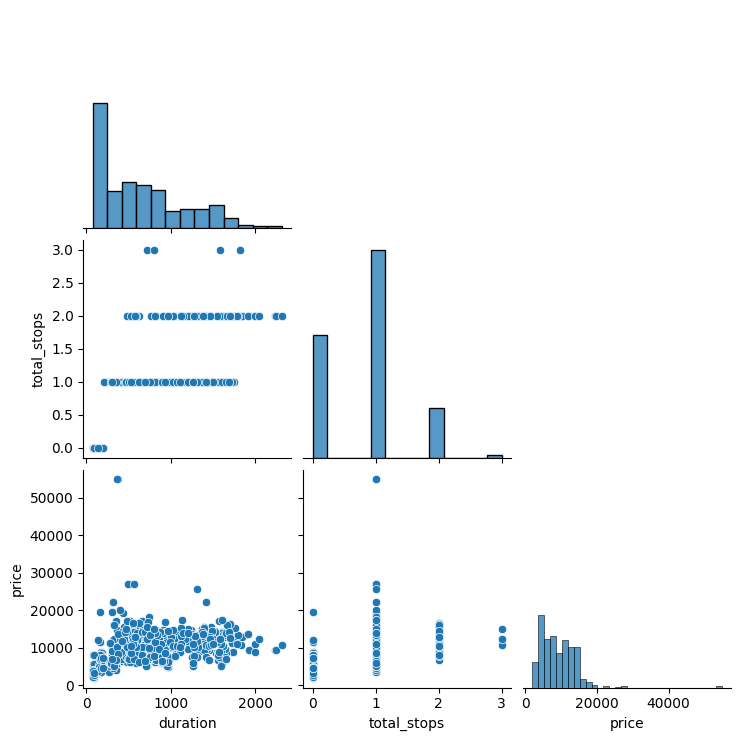

In [30]:
#plot a pair plot graph and only show the lower half triangle
sns.pairplot(train_df, corner=True, aspect=1, height=2.5)

## Correlation Analysis

Correlation Analysis of numeric variables using Pearson Correlation

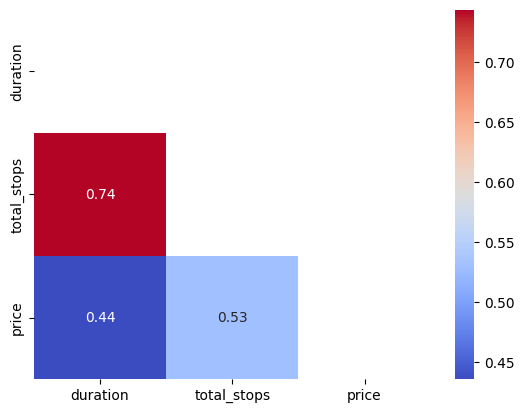

In [ ]:
#by default corr() function uses pearson correlation
numeric_features = train_df.select_dtypes(np.number)
corr = numeric_features.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.show()

### Cramer's V Measure

`Cramér's V` is a statistical measure used to determine the strength of association between two categorical variables. It ranges from 0 to 1, where:

- 0 indicates no association.
- 1 indicates a perfect association.

It's derived from the chi-squared statistic and is useful because it normalizes the chi-squared value to be between 0 and 1, regardless of the table dimensions or sample size, making it easier to interpret the strength of the relationship.



In [ ]:
#Correlation Analysis of categorical variables using Cramer'sV measure
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum() #total number of observations
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Select only categorical columns
cat_cols = train_df.select_dtypes(include=['object']).columns

# Create a DataFrame to store Cramér's V values
cramers_results = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramers_results.loc[col1, col2] = 1.0
        else:
            confusion_matrix = pd.crosstab(train_df[col1], train_df[col2])
            cramers_results.loc[col1, col2] = cramers_v(confusion_matrix)

# Convert results to float for easier analysis
cramers_results = cramers_results.astype(float)
print(cramers_results)

                  airline    source  destination  additional_info
airline          1.000000  0.291208     0.275298         0.500375
source           0.291208  1.000000     1.000000         0.118950
destination      0.275298  1.000000     1.000000         0.137678
additional_info  0.500375  0.118950     0.137678         1.000000


**Here’s how the cramersV function works:**

**Input:**
- It takes a confusion matrix (also called a contingency table) as input. This matrix shows the frequency counts for each combination of categories from the two variables.

**Chi-squared Calculation**:
- It uses chi2_contingency to perform a chi-squared test on the matrix. The first value returned is the chi-squared statistic (chi2).

**Total Observations**:
- It calculates the total number of observations (n) by summing all values in the confusion matrix.

**Phi-squared Calculation**:
- It computes phi-squared (phi2) by dividing the chi-squared statistic by the total number of observations.

**Matrix Dimensions**:
- It gets the number of rows (r) and columns (k) in the confusion matrix.

**Cramér's V Formula**:
- It calculates Cramér's V using the formula:
[ V = \sqrt{\frac{\phi^2}{\min(k-1, r-1)}} ] This formula adjusts for the size of the matrix, ensuring the value is between 0 and 1.

There is no strict universal threshold for interpreting Cramér's V, but commonly used guidelines are:

- 0.00 to 0.10: Negligible association
- 0.10 to 0.20: Weak association
- 0.20 to 0.40: Moderate association
- 0.40 to 0.60: Relatively strong association
- 0.60 to 0.80: Strong association
- 0.80 to 1.00: Very strong association